# Data I

### Import Libraries and Set Up Workspace 🏗️

In [37]:
from azureml.core import Workspace, Datastore
from azureml.core.authentication import InteractiveLoginAuthentication
from azureml.core import Dataset

In [38]:
subscription_id = '0a94de80-6d3b-49f2-b3e9-ec5818862801'#use your subscription id
resource_group = 'buas-y2'#use your resource group
workspace_name = 'Staff-Test'#use your workspace name

# Log in using interactive Auth
auth = InteractiveLoginAuthentication()

# Declare workspace & datastore.
workspace = Workspace(subscription_id=subscription_id,
                      resource_group=resource_group,
                      workspace_name=workspace_name,
                      auth=auth,
                      )

### The above is actually really bad practice. Why? 

### Inspect available data stores and upload data ☁️

In [3]:
# list all datastores registered in the current workspace
datastores = workspace.datastores
for name, datastore in datastores.items():
    print(name, datastore.datastore_type)

workspaceblobstore AzureBlob
workspaceartifactstore AzureBlob
workspaceworkingdirectory AzureFile


In [8]:
# Create a datastore object from the existing datastore named "workspaceblobstore".
datastore = Datastore(workspace, name='workspaceblobstore')

import os
os.listdir('../../../')

# Upload the data to the path target_path in datastore
datastore.upload(src_dir='../../../mnist_data', target_path='mnist-review', overwrite=True, show_progress=True)

"Datastore.upload" is deprecated after version 1.0.69. Please use "Dataset.File.upload_directory" to upload your files             from a local directory and create FileDataset in single method call. See Dataset API change notice at https://aka.ms/dataset-deprecation.


Uploading an estimated of 70000 files
Uploading ../../../mnist_data\test\0\10.jpg
Uploaded ../../../mnist_data\test\0\10.jpg, 1 files out of an estimated total of 70000
Uploading ../../../mnist_data\test\0\1001.jpg
Uploaded ../../../mnist_data\test\0\1001.jpg, 2 files out of an estimated total of 70000
Uploading ../../../mnist_data\test\0\1009.jpg
Uploaded ../../../mnist_data\test\0\1009.jpg, 3 files out of an estimated total of 70000
Uploading ../../../mnist_data\test\0\101.jpg
Uploaded ../../../mnist_data\test\0\101.jpg, 4 files out of an estimated total of 70000
Uploading ../../../mnist_data\test\0\1034.jpg
Uploaded ../../../mnist_data\test\0\1034.jpg, 5 files out of an estimated total of 70000
Uploading ../../../mnist_data\test\0\1047.jpg
Uploaded ../../../mnist_data\test\0\1047.jpg, 6 files out of an estimated total of 70000
Uploading ../../../mnist_data\test\0\1061.jpg
Uploaded ../../../mnist_data\test\0\1061.jpg, 7 files out of an estimated total of 70000
Uploading ../../../mnis

KeyboardInterrupt: 

# Get Data from the Data Store 📚

In [12]:
# Create a FileDataset from a path to a directory.
# The directory contains a folder per class, each of which contains image files.
sample_set = Dataset.File.from_files(path=(datastore, 'mnist'))
paths = sample_set.take_sample(0.1).take(30).download()
print(paths)

{'infer_column_types': 'False', 'activity': 'download'}
{'infer_column_types': 'False', 'activity': 'download', 'activityApp': 'FileDataset'}
['C:\\Users\\deanv\\AppData\\Local\\Temp\\tmpmkha0crg\\0/63.png', 'C:\\Users\\deanv\\AppData\\Local\\Temp\\tmpmkha0crg\\2/117.png', 'C:\\Users\\deanv\\AppData\\Local\\Temp\\tmpmkha0crg\\2/122.png', 'C:\\Users\\deanv\\AppData\\Local\\Temp\\tmpmkha0crg\\3/44.png', 'C:\\Users\\deanv\\AppData\\Local\\Temp\\tmpmkha0crg\\3/50.png', 'C:\\Users\\deanv\\AppData\\Local\\Temp\\tmpmkha0crg\\5/0.png', 'C:\\Users\\deanv\\AppData\\Local\\Temp\\tmpmkha0crg\\5/145.png', 'C:\\Users\\deanv\\AppData\\Local\\Temp\\tmpmkha0crg\\5/35.png', 'C:\\Users\\deanv\\AppData\\Local\\Temp\\tmpmkha0crg\\6/73.png', 'C:\\Users\\deanv\\AppData\\Local\\Temp\\tmpmkha0crg\\7/71.png', 'C:\\Users\\deanv\\AppData\\Local\\Temp\\tmpmkha0crg\\9/80.png']


IndexError: index 2 is out of bounds for axis 0 with size 2

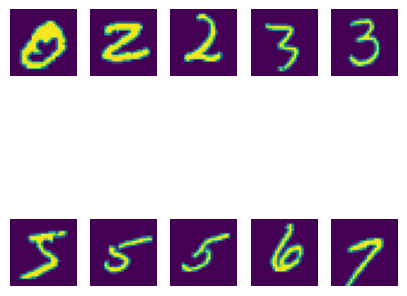

In [14]:
# Plot the images in a grid 5x5
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

fig, axs = plt.subplots(2, 5, figsize=(5, 5))
for i, path in enumerate(paths):
    img = mpimg.imread(path)
    axs[i // 5, i % 5].imshow(img)
    axs[i // 5, i % 5].axis('off')
plt.show()


### Create and Register a Training, Validation and Test Dataset 📝

In [16]:
# Create a FileDataset from a path to a directory for the training data.
train_set = Dataset.File.from_files(path=(datastore, ''))
# Split the dataset into train and validation sets
train_set, val_set = train_set.random_split(0.8, seed=123)
# Create a FileDataset from a path to a directory for the test data.
# test_set = Dataset.File.from_files(path=(datastore, 'mnist/test'))

#register the datasets
train_reg = train_set.register(workspace=workspace, name='train_data_review', description='training data', create_new_version=True)
val_reg = val_set.register(workspace=workspace, name='test_data_review', description='validation data', create_new_version=True)
# test_reg = test_set.register(workspace=workspace, name='digits_test', description='test data', create_new_version=True)

# Environments

### What is an Environment? 🤔

### Create an Environment 🛠️ (using SDKv2)

- From a Docker Image 🐳
- From a Docker File 📄 (build context)
- From a Conda Specification 📦

Connect to the ML_Client 🤝

In [40]:
# import required libraries
from azure.ai.ml import MLClient
from azure.ai.ml.entities import Environment, BuildContext
from azure.identity import InteractiveBrowserCredential

credential = InteractiveBrowserCredential()
workspace_name = "Staff-Test"
# get a handle to the workspace
ml_client = MLClient(
    credential, subscription_id, resource_group, workspace_name
)

Docker Image 🐳

In [38]:
base_image = "deanis/azure-gpu-inference:latest"#"tensorflow/tensorflow:latest-gpu"#"mcr.microsoft.com/azureml/curated/tensorflow-2.16-cuda11:2" # Where to get the base image from? 

env_docker_image = Environment(
    image=base_image,
    name="endpoint_env_inference",
    description="Environment created from a Docker image.",
)
ml_client.environments.create_or_update(env_docker_image)

Environment({'arm_type': 'environment_version', 'latest_version': None, 'image': 'deanis/azure-gpu-inference:latest', 'intellectual_property': None, 'is_anonymous': False, 'auto_increment_version': False, 'auto_delete_setting': None, 'name': 'endpoint_env_inference', 'description': 'Environment created from a Docker image.', 'tags': {}, 'properties': {'azureml.labels': 'latest'}, 'print_as_yaml': False, 'id': '/subscriptions/0a94de80-6d3b-49f2-b3e9-ec5818862801/resourceGroups/buas-y2/providers/Microsoft.MachineLearningServices/workspaces/Staff-Test/environments/endpoint_env_inference/versions/2', 'Resource__source_path': '', 'base_path': 'c:\\Users\\deanv\\Dropbox\\0_Buas\\2023-2024\\y2D\\Azure Content Testing\\Example-App-master\\Example-App-master\\Notebooks', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x0000015809F84210>, 'serialize': <msrest.serialization.Serializer object at 0x000001580A153890>, 'version': '2', 'conda_file': None, 'build': None, 'i

Docker File 📄 (build context)

In [21]:
env_docker_context = Environment(
    build=BuildContext(path="../../../docker-contexts/tensorflow"),
    name="docker-context-example",
    description="Environment created from a Docker context.",
)
ml_client.environments.create_or_update(env_docker_context)

Environment({'arm_type': 'environment_version', 'latest_version': None, 'image': None, 'intellectual_property': None, 'is_anonymous': False, 'auto_increment_version': False, 'auto_delete_setting': None, 'name': 'docker-context-example', 'description': 'Environment created from a Docker context.', 'tags': {}, 'properties': {'azureml.labels': 'latest'}, 'print_as_yaml': False, 'id': '/subscriptions/0a94de80-6d3b-49f2-b3e9-ec5818862801/resourceGroups/buas-y2/providers/Microsoft.MachineLearningServices/workspaces/Staff-Test/environments/docker-context-example/versions/3', 'Resource__source_path': '', 'base_path': 'c:\\Users\\deanv\\Dropbox\\0_Buas\\2023-2024\\y2D\\Azure Content Testing\\Example-App-master\\Example-App-master\\Notebooks', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x0000015809C57B90>, 'serialize': <msrest.serialization.Serializer object at 0x0000015809C568D0>, 'version': '3', 'conda_file': None, 'build': <azure.ai.ml.entities._assets.environ

Conda Specification 📦

In [22]:
env_docker_conda = Environment(
    image="mcr.microsoft.com/azureml/openmpi4.1.0-ubuntu20.04",
    conda_file="../../../example_conda.yml",
    name="docker-image-plus-conda-example",
    description="Environment created from a Docker image plus Conda environment.",
)
ml_client.environments.create_or_update(env_docker_conda)

Environment({'arm_type': 'environment_version', 'latest_version': None, 'image': 'mcr.microsoft.com/azureml/openmpi4.1.0-ubuntu20.04', 'intellectual_property': None, 'is_anonymous': False, 'auto_increment_version': False, 'auto_delete_setting': None, 'name': 'docker-image-plus-conda-example', 'description': 'Environment created from a Docker image plus Conda environment.', 'tags': {}, 'properties': {'azureml.labels': 'latest'}, 'print_as_yaml': False, 'id': '/subscriptions/0a94de80-6d3b-49f2-b3e9-ec5818862801/resourceGroups/buas-y2/providers/Microsoft.MachineLearningServices/workspaces/Staff-Test/environments/docker-image-plus-conda-example/versions/2', 'Resource__source_path': '', 'base_path': 'c:\\Users\\deanv\\Dropbox\\0_Buas\\2023-2024\\y2D\\Azure Content Testing\\Example-App-master\\Example-App-master\\Notebooks', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x000001580984C310>, 'serialize': <msrest.serialization.Serializer object at 0x0000015809C560

### Checking the registered environments in your Azure Machine Learning Workspace ✅

In [41]:
# List all available environments.
envs = ml_client.environments.list()
for env in envs:
    print(f"Environment name: {env.name}, latest version: {env.latest_version}")

Environment name: CliV2AnonymousEnvironment, latest version: 0
Environment name: endpoint_env_inference, latest version: 2
Environment name: docker-image-plus-conda-example, latest version: 2
Environment name: docker-context-example, latest version: 3
Environment name: docker-image-example, latest version: 5
Environment name: tf-gpu-docker-2, latest version: 2
Environment name: tf-gpu-docker, latest version: 2
Environment name: tf-curated, latest version: 2
Environment name: tf-gpu, latest version: 1
Environment name: basic-tf-gpu, latest version: 11
Environment name: basic-python, latest version: 1
Environment name: my-docker-environment, latest version: 1
Environment name: my_docker_environment, latest version: 1
Environment name: AzureML-ACPT-pytorch-1.13-py38-cuda11.7-gpu, latest version: 10


## Docker Demo 🐳

- Create a Docker Image
- Run a Docker Container
- Push a Docker Image to a Container Registry

# Data II

### Consuming Data from Azure Machine Learning Datasets 📚

In [45]:
# Step 1 is to connect to the ml_client, but we have already done that.

env = ml_client.environments.get("tf-gpu-docker-2", 2)
compute_target = "adsai1"
data_asset = ml_client.data.get("digits_train_2", version="1")

In [27]:
from azure.ai.ml import Input, MLClient, command
from azure.ai.ml.constants import AssetTypes, InputOutputModes

job = command(
        #command='ls "${{inputs.data}}"',
        command='find "${{inputs.data}}"',
        inputs={
            "data": Input(path=data_asset.id,
                type=AssetTypes.MLTABLE,
                mode=InputOutputModes.RO_MOUNT
            )
        },
        environment="azureml:AzureML-sklearn-1.0-ubuntu20.04-py38-cpu@latest",
        compute=compute_target,
        instance_type="cpu-med"
      )
returned_job = ml_client.jobs.create_or_update(job)

Class AutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class AutoDeleteConditionSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseAutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class IntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class ProtectionLevelSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseIntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


# Command Jobs 🚀

In [47]:
from azure.ai.ml import Input, MLClient, command
from azure.ai.ml.constants import AssetTypes, InputOutputModes

job = command(
    inputs=dict(
        data=Input(path=data_asset.id,
                type=AssetTypes.MLTABLE,
                mode=InputOutputModes.RO_MOUNT),
        test_train_ratio=0.2,
    ),
    code="../src/number_predictor",  # location of source code
    command="python train.py --use-uri --data-path ${{inputs.data}} --test-train-ratio ${{inputs.test_train_ratio}}",
    environment=env,
    compute=compute_target,
    instance_type="gpu",
    instance_count=1,
    display_name="number prediction",
)

ml_client.create_or_update(job)

Uploading number_predictor (4.34 MBs): 100%|##########| 4338807/4338807 [00:02<00:00, 1632470.40it/s]




Experiment,Name,Type,Status,Details Page
Notebooks,happy_band_k9h7d3bxn6,command,Starting,Link to Azure Machine Learning studio


Exception occurred while exporting the data.
Traceback (most recent call last):
  File "C:\Users\deanv\AppData\Roaming\Python\Python311\site-packages\opencensus\ext\azure\trace_exporter\__init__.py", line 228, in emit
    self._transmit_from_storage()
  File "C:\Users\deanv\AppData\Roaming\Python\Python311\site-packages\opencensus\ext\azure\common\transport.py", line 80, in _transmit_from_storage
    for blob in self.storage.gets():
  File "C:\Users\deanv\AppData\Roaming\Python\Python311\site-packages\opencensus\ext\azure\common\storage.py", line 129, in gets
    for name in sorted(os.listdir(self.path)):
                       ^^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\deanv\\AppData\\Local\\Temp\\opencensus-python-71b954a8-6b7d-43f5-986c-3d3a6605d803'
Exception occurred while exporting the data.
Traceback (most recent call last):
  File "C:\Users\deanv\AppData\Roaming\Python\Python311\site-packages\opencensus\ext\azure

# Pipelines 🛠️

- Made up of components
- Components are reusable
- Components feed into each other

We will create a pipeline that trains a model, evaluates it, and registers it in the Azure Machine Learning Workspace.

3 Components:

1. Train Model
    - Inputs
        - Training Dataset
        - Arguments
    - Output
        - Model
2. Evaluate Model
    - Inputs
        - Model
        - Validation Dataset
    - Output
        - Metrics
3. Register Model
    - Inputs
        - Model
        - Metrics



### Service Principal Authentication 🛡️

In [48]:
from azure.ai.ml import Input, MLClient, Output, command, dsl
from azure.identity import ClientSecretCredential
from azureml.core import Workspace
from azureml.core.authentication import ServicePrincipalAuthentication

subscription_id = "0a94de80-6d3b-49f2-b3e9-ec5818862801"
resource_group = "buas-y2"
workspace_name = "Staff-Test"
tenant_id = "0a33589b-0036-4fe8-a829-3ed0926af886"
client_id = "a2230f31-0fda-428d-8c5c-ec79e91a49f5"
client_secret = "Y-q8Q~H63btsUkR7dnmHrUGw2W0gMWjs0MxLKa1C"

service_principal = ServicePrincipalAuthentication(
    tenant_id=tenant_id,
    service_principal_id=client_id,
    service_principal_password=client_secret,
)

workspace = Workspace(subscription_id, resource_group, workspace_name, auth=service_principal)

credential = ClientSecretCredential(tenant_id, client_id, client_secret)

ml_client = MLClient(credential, subscription_id, resource_group, workspace_name)

In [49]:
environments = ml_client.environments.list()
print("Environments:\n")
for environment in environments:
    print(
        environment.name,
        ":",
        environment.latest_version,
    )
print("-------------------")

# List all available datasets
datasets = ml_client.data.list()
print("Datasets:\n")
for dataset in datasets:
    print(dataset.name, ":", dataset.latest_version)
print("-------------------")

# List all available compute targets
compute_targets = ml_client.compute.list()
print("Compute targets:\n")
for compute_target in compute_targets:
    print(compute_target.name, "-", compute_target.type)
print("-------------------")

Environments:

CliV2AnonymousEnvironment : 0
endpoint_env_inference : 2
docker-image-plus-conda-example : 2
docker-context-example : 3
docker-image-example : 5
tf-gpu-docker-2 : 2
tf-gpu-docker : 2
tf-curated : 2
tf-gpu : 1
basic-tf-gpu : 11
basic-python : 1
my-docker-environment : 1
my_docker_environment : 1
AzureML-ACPT-pytorch-1.13-py38-cuda11.7-gpu : 10
-------------------
Datasets:

digits_train : 1
digits_val : 1
digits_test : 1
mnist_dataset_v2 : 1
digits_train_2 : 1
digits_val_2 : 1
dataset : 2223022f
train_data_review : 1
test_data_review : 1
-------------------
Compute targets:

Vultr - kubernetes
adsai1 - kubernetes
adsai0 - kubernetes
-------------------


Training Component 🏋️

In [58]:
environment_name = "tf-gpu-docker-2"
environment_version = 2
print(f"Using environment {environment_name} version {environment_version}")
compute_target_name = "adsai1"


component_path = "../src/number_predictor/"
env = ml_client.environments.get(environment_name, environment_version)


train_component = command(
    name="train",
    display_name="Train model",
    description="Train model with data from a predefined data asset",
    inputs={
        "data": Input(type="uri_folder", description="Data asset URI"),
    },
    outputs=dict(model=Output(type="uri_folder", mode="rw_mount")),
    code=component_path,
    command="python train.py --use-uri --data-path ${{inputs.data}} --model-path ${{outputs.model}}",
    environment=env,
    compute=compute_target_name,#compute_target.name,
    instance_type="gpu",
    instance_count=1,

)

train_component = ml_client.create_or_update(train_component.component)

Using environment tf-gpu-docker-2 version 2


Evaluation Component 📊

In [59]:
evaluate_component = command(
    name="evaluate",
    display_name="Evaluate model",
    description="Evaluate model with data from a predefined data asset",
    inputs={
        "data": Input(type="uri_folder", description="Data asset URI"),
        "model": Input(type="uri_folder", description="Model URI", mode="download"),
    },
    outputs=dict(
        accuracy=Output(type="uri_folder", description="Model accuracy output")
    ),
    code=component_path,
    command="python evaluate.py --use_uri --test_data_dir ${{inputs.data}} --model_path ${{inputs.model}} --accuracy_path ${{outputs.accuracy}}",
    environment=env,
    compute=compute_target_name,
    # compute_target=compute_target_name
)

evaluate_component = ml_client.create_or_update(evaluate_component.component)

Register Component 📝

In [64]:
register_component = command(
    name="register",
    display_name="Register model",
    description="Register model with data from a predefined data asset",
    inputs={
        "model": Input(type="uri_folder", description="Model URI"),
        "accuracy": Input(type="uri_folder", description="Model accuracy file"),
    },
    code=component_path,
    command="python register.py --model ${{inputs.model}} --accuracy ${{inputs.accuracy}}",
    environment=env,
    compute=compute_target_name,
    # compute_target=compute_target_name
)

register_component = ml_client.create_or_update(register_component.component)

Creating a Pipeline 🛠️

In [65]:
# list all components
components = ml_client.components.list()
print("Components:\n")
for component in components:
    print(component.name, ":", component.latest_version)
print("-------------------")

Components:

register : None
evaluate : None
train : None
-------------------


In [68]:
@dsl.pipeline(
    name="Example pipeline",
    compute="adsai1",  
    # instance_type="gpu"#"cpularge"#"defaultinstancetype",
)
def train_eval_reg_pipeline(
    train_data_asset_uri: str,
    test_data_asset_uri: str,
) -> None:
    training_step = train_component(data=train_data_asset_uri)
    evaluation_step = evaluate_component(
        data=test_data_asset_uri, model=training_step.outputs.model
    )
    register_step = register_component(
        model=training_step.outputs.model, accuracy=evaluation_step.outputs.accuracy
    )

In [69]:
train_data_asset = ml_client.data.get("digits_train_2", version="1")
val_data_asset = ml_client.data.get("digits_val_2", version="1")

train_digits_ds = Input(
    path=train_data_asset.id
)
print(train_digits_ds)
test_digits_ds = Input(
    path=val_data_asset.id
)
print(test_digits_ds)


# Instantiate the pipeline.
pipeline_instance = train_eval_reg_pipeline(
    train_data_asset_uri=train_digits_ds, test_data_asset_uri=test_digits_ds
)

# Submit the pipeline.
pipeline_run = ml_client.jobs.create_or_update(pipeline_instance)

{'type': 'uri_folder', 'path': '/subscriptions/0a94de80-6d3b-49f2-b3e9-ec5818862801/resourceGroups/buas-y2/providers/Microsoft.MachineLearningServices/workspaces/Staff-Test/data/digits_train_2/versions/1'}
{'type': 'uri_folder', 'path': '/subscriptions/0a94de80-6d3b-49f2-b3e9-ec5818862801/resourceGroups/buas-y2/providers/Microsoft.MachineLearningServices/workspaces/Staff-Test/data/digits_val_2/versions/1'}


Exception occurred while exporting the data.
Traceback (most recent call last):
  File "C:\Users\deanv\AppData\Roaming\Python\Python311\site-packages\opencensus\ext\azure\trace_exporter\__init__.py", line 228, in emit
    self._transmit_from_storage()
  File "C:\Users\deanv\AppData\Roaming\Python\Python311\site-packages\opencensus\ext\azure\common\transport.py", line 80, in _transmit_from_storage
    for blob in self.storage.gets():
  File "C:\Users\deanv\AppData\Roaming\Python\Python311\site-packages\opencensus\ext\azure\common\storage.py", line 129, in gets
    for name in sorted(os.listdir(self.path)):
                       ^^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\deanv\\AppData\\Local\\Temp\\opencensus-python-71b954a8-6b7d-43f5-986c-3d3a6605d803'
Exception occurred while exporting the data.
Traceback (most recent call last):
  File "C:\Users\deanv\AppData\Roaming\Python\Python311\site-packages\opencensus\ext\azure